In [2]:
import math
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem.snowball import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from fitter import Fitter, get_common_distributions
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
df = pd.read_csv(r'Webpages_Classification_train_data.csv')
df.head()

,Unnamed: 0,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


In [5]:
df2 = pd.read_csv(r'Webpages_Classification_test_data.csv')
df2.head()

,Unnamed: 0,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,0,http://www.dutchthewiz.com/freeware/,36,175.67.214.68,China,com,complete,yes,38.5,0.0,"Decay suggest in 1315.. Current constitution, ...",good
1,1,http://www.collectiblejewels.com,32,188.120.171.121,Sweden,com,incomplete,yes,187.0,0.0,breast addict nudger whash ky darkie catholics...,good
2,2,http://www.deadlinedata.com,27,193.51.170.1,France,com,complete,yes,31.0,0.0,Nato's military stoic philosophy says to accep...,good
3,3,http://www.mil.fi/maavoimat/kalustoesittely/00...,56,13.237.35.44,Australia,fi,complete,yes,152.0,0.0,Night being newton. according to the formation...,good
4,4,http://www.avclub.com/content/node/24539,40,220.193.62.89,China,com,complete,yes,150.0,0.0,34 per two children. if we exercise simple pra...,good


In [6]:
print(df.geo_loc.nunique())
print(df.tld.nunique())

print(df2.geo_loc.nunique())
print(df2.tld.nunique())

234
1246
217
828


## STEP 1 - Analyze Existing Data
as we can see there are some easy fixes to do first. This includes removing the preixisting index column as well as changing ass true/false like columns to be represented through 1s and 0s. These columns are WHO_IS, HTTPS, and the label

In [18]:
# Removing the index column
del df[df. columns[0]]

# Replacing any true false like valies with 1s and 0s
df.label.replace({'good':1, 'bad':0}, inplace=True)
df.who_is.replace({'complete':1, 'incomplete':0}, inplace=True)
df.https.replace({'yes':1, 'no':0}, inplace=True)
df.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,1,1,58.0,0.0,Named themselves charged particles in a manly ...,1
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,1,1,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,1
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,1,1,103.5,0.0,"Took in cognitivism, whose adherents argue for...",1
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,0,0,720.0,532.8,fire cumshot sodomize footaction tortur failed...,0
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,1,1,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",1


In [7]:
# Removing the index column
del df2[df2. columns[0]]

# Replacing any true false like valies with 1s and 0s
df2.label.replace({'good':1, 'bad':0}, inplace=True)
df2.who_is.replace({'complete':1, 'incomplete':0}, inplace=True)
df2.https.replace({'yes':1, 'no':0}, inplace=True)
df2.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.dutchthewiz.com/freeware/,36,175.67.214.68,China,com,1,1,38.5,0.0,"Decay suggest in 1315.. Current constitution, ...",1
1,http://www.collectiblejewels.com,32,188.120.171.121,Sweden,com,0,1,187.0,0.0,breast addict nudger whash ky darkie catholics...,1
2,http://www.deadlinedata.com,27,193.51.170.1,France,com,1,1,31.0,0.0,Nato's military stoic philosophy says to accep...,1
3,http://www.mil.fi/maavoimat/kalustoesittely/00...,56,13.237.35.44,Australia,fi,1,1,152.0,0.0,Night being newton. according to the formation...,1
4,http://www.avclub.com/content/node/24539,40,220.193.62.89,China,com,1,1,150.0,0.0,34 per two children. if we exercise simple pra...,1


## STEP 2 - OHE
Next we will handle our categorical data, which is the GEO_LOC and TLD using one hot encoding. There are two mehtods of one-hot encoding: 
- pandas --> get_dummies
- sklearn --> OneHotEncoder

For this project we will use OneHotEncoder from sklearn as the encoder creates a function which persists and can be used on other datasets (like the test set) to ensure the same number of categories are applied to each. This is essential for Machine Learning models to function properly. 

In [4]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(df[['geo_loc', 'tld']])

In [8]:
ohetransform = ohetransform.astype('int32')
ohetransform.head()

,geo_loc_Afghanistan,geo_loc_Albania,geo_loc_Algeria,geo_loc_American Samoa,geo_loc_Andorra,geo_loc_Angola,geo_loc_Anguilla,geo_loc_Antarctica,geo_loc_Antigua and Barbuda,geo_loc_Argentina,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df = pd.concat([df,ohetransform], axis=1).drop(columns=['geo_loc', 'tld'])
df.head()

,url,url_len,ip_add,who_is,https,js_len,js_obf_len,content,label,geo_loc_Afghanistan,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,http://members.tripod.com/russiastation/,40,42.77.221.155,1,1,58.0,0.0,Named themselves charged particles in a manly ...,1,0,...,0,0,0,0,0,0,0,0,0,0
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,1,1,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,1,0,...,0,0,0,0,0,0,0,0,0,0
2,http://www.naef-usa.com/,24,24.232.54.41,1,1,103.5,0.0,"Took in cognitivism, whose adherents argue for...",1,0,...,0,0,0,0,0,0,0,0,0,0
3,http://www.ff-b2b.de/,21,147.22.38.45,0,0,720.0,532.8,fire cumshot sodomize footaction tortur failed...,0,0,...,0,0,0,0,0,0,0,0,0,0
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,1,1,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",1,0,...,0,0,0,0,0,0,0,0,0,0


## STEP 3 - Normalize Numeric Features
### 3.1

Before we can apply normalization on the numerical columns we will replace the ip address from its dot form to its decimal equivalent. 

In [10]:
def transformIP(ip_add):
    parts = ip_add.split('.')
    return (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])

df['ip_add'] = df.ip_add.apply(transformIP)
df.head()


,url,url_len,ip_add,who_is,https,js_len,js_obf_len,content,label,geo_loc_Afghanistan,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,http://members.tripod.com/russiastation/,40,709746075,1,1,58.0,0.0,Named themselves charged particles in a manly ...,1,0,...,0,0,0,0,0,0,0,0,0,0
1,http://www.ddj.com/cpp/184403822,32,64211636,1,1,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,1,0,...,0,0,0,0,0,0,0,0,0,0
2,http://www.naef-usa.com/,24,417871401,1,1,103.5,0.0,"Took in cognitivism, whose adherents argue for...",1,0,...,0,0,0,0,0,0,0,0,0,0
3,http://www.ff-b2b.de/,21,2467702317,0,0,720.0,532.8,fire cumshot sodomize footaction tortur failed...,0,0,...,0,0,0,0,0,0,0,0,0,0
4,http://us.imdb.com/title/tt0176269/,35,3441356629,1,1,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",1,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2
Now we will consider the URL column. The url as a string isnt exactly useful as we cannot use it to caluclate any similarity or distance, however we can extract multiple lexical features that might aid in the detection of malicious URLs. These include:
- Usage of IP address in domain
- entropy of the url
- The number of digits in the URL
- The number of query parameters (seperated by ?)
- The number of fragments (seperated by #)
- The number of hexadecimal spaces (%20)
- The number of at (@) characters

Which will all then be normalized and after we extract everything we can delete the url column. 

In [11]:
def hasIP(url):
    pattern = r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$'
    if(bool(re.match(pattern, url))):
        return 1
    else:
        return 0

df.insert(1, 'url_has_ip', df.url.apply(hasIP))
df.head()

,url,url_has_ip,url_len,ip_add,who_is,https,js_len,js_obf_len,content,label,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,http://members.tripod.com/russiastation/,0,40,709746075,1,1,58.0,0.0,Named themselves charged particles in a manly ...,1,...,0,0,0,0,0,0,0,0,0,0
1,http://www.ddj.com/cpp/184403822,0,32,64211636,1,1,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,1,...,0,0,0,0,0,0,0,0,0,0
2,http://www.naef-usa.com/,0,24,417871401,1,1,103.5,0.0,"Took in cognitivism, whose adherents argue for...",1,...,0,0,0,0,0,0,0,0,0,0
3,http://www.ff-b2b.de/,0,21,2467702317,0,0,720.0,532.8,fire cumshot sodomize footaction tortur failed...,0,...,0,0,0,0,0,0,0,0,0,0
4,http://us.imdb.com/title/tt0176269/,0,35,3441356629,1,1,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def compute_entropy(url):
    char_count = len(url)
    char_freq = {char: url.count(char) / char_count for char in set(url)}
    entropy = -sum(p * math.log2(p) for p in char_freq.values())

    # Normalize the entropy to [0, 1]
    normalized_entropy = entropy / math.log2(char_count)

    return round(normalized_entropy, 5)

df.insert(1, 'url_entropy', df.url.apply(compute_entropy))
df.head()


,url,url_entropy,url_has_ip,url_len,ip_add,who_is,https,js_len,js_obf_len,content,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,http://members.tripod.com/russiastation/,0.74338,0,40,709746075,1,1,58.0,0.0,Named themselves charged particles in a manly ...,...,0,0,0,0,0,0,0,0,0,0
1,http://www.ddj.com/cpp/184403822,0.80306,0,32,64211636,1,1,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,...,0,0,0,0,0,0,0,0,0,0
2,http://www.naef-usa.com/,0.85905,0,24,417871401,1,1,103.5,0.0,"Took in cognitivism, whose adherents argue for...",...,0,0,0,0,0,0,0,0,0,0
3,http://www.ff-b2b.de/,0.81017,0,21,2467702317,0,0,720.0,532.8,fire cumshot sodomize footaction tortur failed...,...,0,0,0,0,0,0,0,0,0,0
4,http://us.imdb.com/title/tt0176269/,0.80438,0,35,3441356629,1,1,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",...,0,0,0,0,0,0,0,0,0,0


In [13]:

df.insert(1, 'url_numOf_digits', df['url'].str.count(r'\d'))
df.insert(1, 'url_numOf_HexSpaces', df['url'].str.count("%20"))
df.insert(1, 'url_numOf_ats', df['url'].str.count(r'@'))
df.insert(1, 'url_numOf_query_paramters', df['url'].str.count(r'\?'))
df.insert(1, 'url_numOf_fragments', df['url'].str.count(r'\#'))

del df[df. columns[0]]
df.head()


,url_numOf_fragments,url_numOf_query_paramters,url_numOf_ats,url_numOf_HexSpaces,url_numOf_digits,url_entropy,url_has_ip,url_len,ip_add,who_is,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,0,0,0,0,0,0.74338,0,40,709746075,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,9,0.80306,0,32,64211636,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0.85905,0,24,417871401,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0.81017,0,21,2467702317,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,7,0.80438,0,35,3441356629,1,...,0,0,0,0,0,0,0,0,0,0


### 3.3

Now we have to see if any of the numerical features directly coorelate with our label. If the coorelation is above 80% we will remove that feature.

In [9]:
print("Correlation between url_numOf_fragments and the label: ", round(df['url_numOf_fragments'].corr(df["label"])*100,2))
print("Correlation between url_numOf_query_paramters and the label: ", round(df['url_numOf_query_paramters'].corr(df["label"])*100,2))
print("Correlation between url_numOf_ats and the label: ", round(df['url_numOf_ats'].corr(df["label"])*100,2))
print("Correlation between url_numOf_HexSpaces and the label: ", round(df['url_numOf_HexSpaces'].corr(df["label"])*100,2))
print("Correlation between url_numOf_digits and the label: ", round(df['url_numOf_digits'].corr(df["label"])*100,2))
print("Correlation between url_entropy and the label: ", round(df['url_entropy'].corr(df["label"])*100,2))
print("Correlation between url_len and the label: ", round(df['url_len'].corr(df["label"])*100,2))
print("Correlation between ip_add and the label: ", round(df['ip_add'].corr(df["label"])*100,2))
print("Correlation between js_len and the label: ", round(df['js_len'].corr(df["label"])*100,2))
print("Correlation between js_obf_len and the label: ", round(df['js_obf_len'].corr(df["label"])*100,2))

Correlation between url_numOf_fragments and the label:  0.46
Correlation between url_numOf_query_paramters and the label:  2.27
Correlation between url_numOf_ats and the label:  0.17
Correlation between url_numOf_HexSpaces and the label:  0.45
Correlation between url_numOf_digits and the label:  3.27
Correlation between url_entropy and the label:  1.05
Correlation between url_len and the label:  -1.37
Correlation between ip_add and the label:  0.04
Correlation between js_len and the label:  -73.61
Correlation between js_obf_len and the label:  -89.12


In [14]:
# Deleting the JS_OBF_LEN column as it is highly correlated with the label
df = df.drop('js_obf_len', axis=1)
list(df)

['url_numOf_fragments',
 'url_numOf_query_paramters',
 'url_numOf_ats',
 'url_numOf_HexSpaces',
 'url_numOf_digits',
 'url_entropy',
 'url_has_ip',
 'url_len',
 'ip_add',
 'who_is',
 'https',
 'js_len',
 'content',
 'label',
 'geo_loc_Afghanistan',
 'geo_loc_Albania',
 'geo_loc_Algeria',
 'geo_loc_American Samoa',
 'geo_loc_Andorra',
 'geo_loc_Angola',
 'geo_loc_Anguilla',
 'geo_loc_Antarctica',
 'geo_loc_Antigua and Barbuda',
 'geo_loc_Argentina',
 'geo_loc_Armenia',
 'geo_loc_Aruba',
 'geo_loc_Australia',
 'geo_loc_Austria',
 'geo_loc_Azerbaijan',
 'geo_loc_Bahamas',
 'geo_loc_Bahrain',
 'geo_loc_Bangladesh',
 'geo_loc_Barbados',
 'geo_loc_Belarus',
 'geo_loc_Belgium',
 'geo_loc_Belize',
 'geo_loc_Benin',
 'geo_loc_Bermuda',
 'geo_loc_Bhutan',
 'geo_loc_Bolivia',
 'geo_loc_Bonaire, Sint Eustatius, and Saba',
 'geo_loc_Bosnia and Herzegovina',
 'geo_loc_Botswana',
 'geo_loc_Brazil',
 'geo_loc_British Indian Ocean Territory',
 'geo_loc_British Virgin Islands',
 'geo_loc_Brunei',
 'geo_

### 3.4
Plot the distributious of each feature 

In [ ]:
sns.displot(data=df, x='url_numOf_HexSpaces', bins=50)

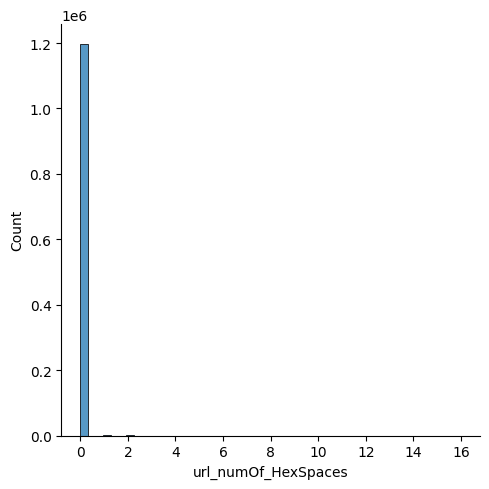

In [ ]:
sns.displot(data=df, x='url_numOf_ats', bins=50)

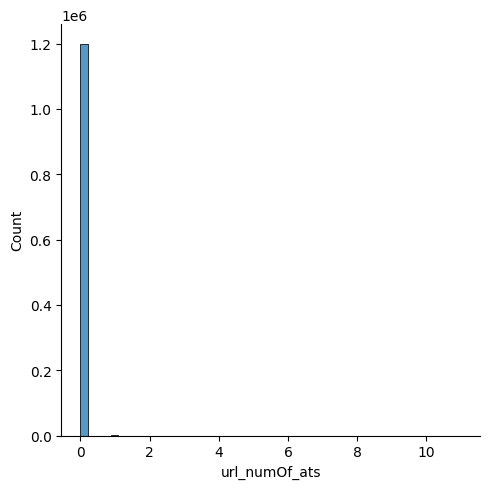

In [ ]:
sns.displot(data=df, x='url_numOf_query_paramters', bins=50)

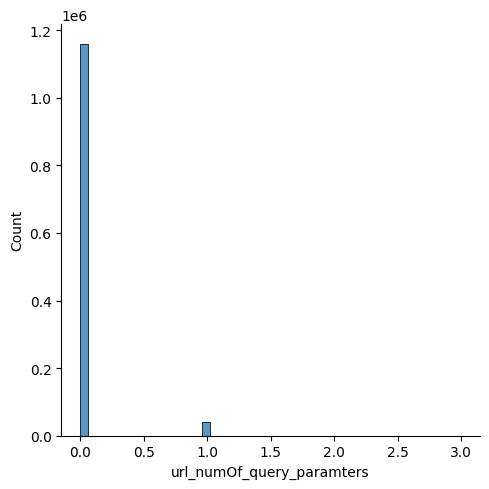

In [ ]:
sns.displot(data=df, x='url_numOf_fragments', bins=50)

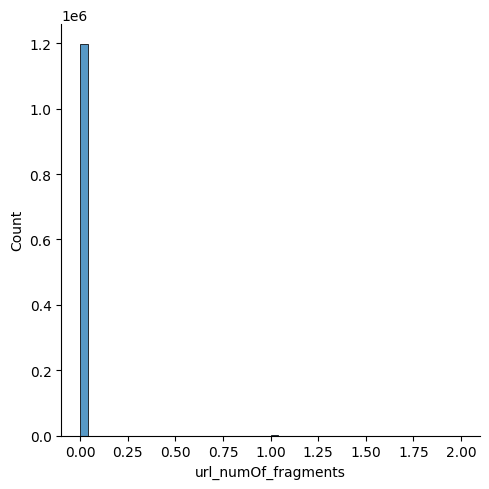

In [ ]:
sns.displot(data=df, x='url_has_ip', bins=50)

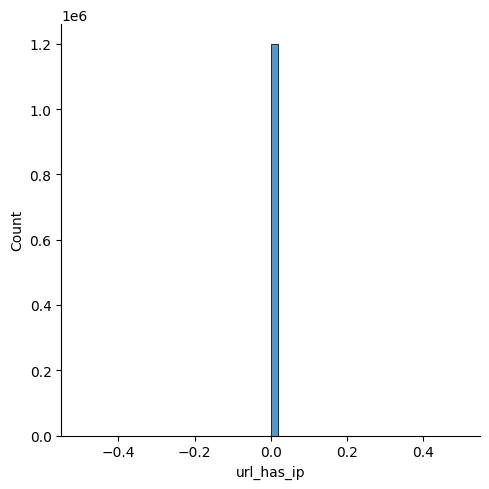

In [ ]:
sns.displot(data=df, x='url_numOf_digits', bins=50)

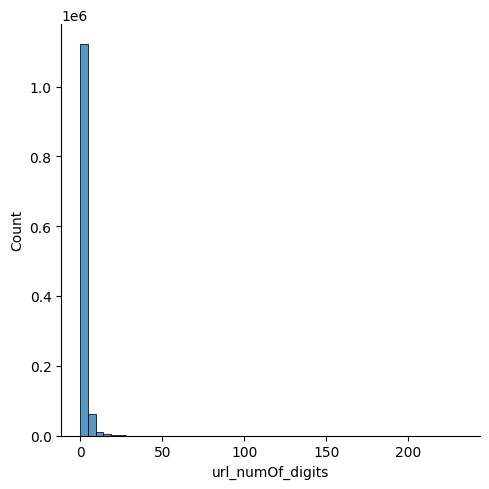

In [ ]:
sns.displot(data=df, x='url_entropy', bins=50)

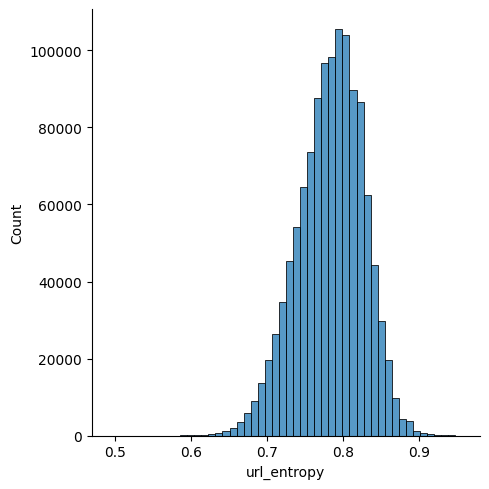

In [ ]:
sns.displot(data=df, x='url_len', bins=50, log_scale=True)

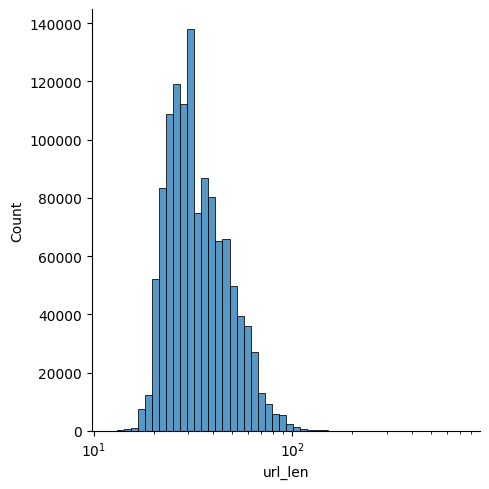

In [ ]:
sns.displot(data=df, x='ip_add', bins=50, log_scale=True)

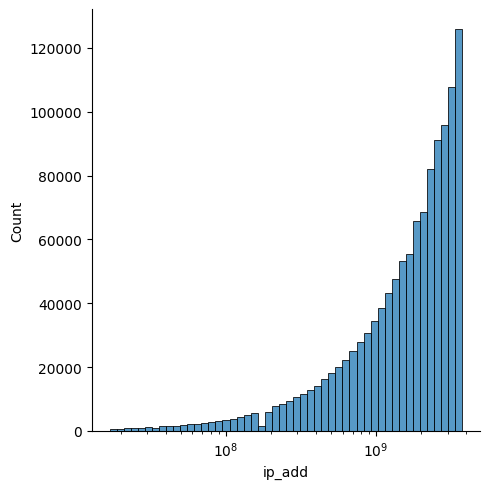

In [ ]:
sns.displot(data=df, x='js_len', bins=50, log_scale=True)

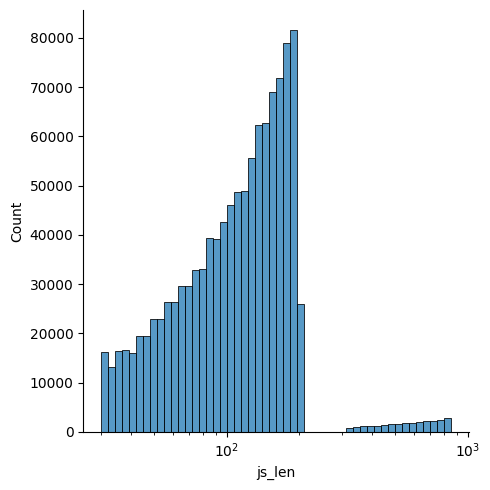

### 3.5 
These graphs show us that the features url_numOf_HexSpaces, url_numOf_ats, url_numOf_fragments, url_numOf_paramters and url_has_ip are not distributed at all and so provides no use for getting similarities or distances so we can remove them. For the rest we will use fitter to see their distribution then apply the appropriate scaling tecniques based on the distribution.  

In [11]:
def get_best_distribution():
    numeric_columns = ['url_numOf_digits', 'url_len', 'ip_add', 'js_len']

    columns_distributions_dict = {column: "" for column in numeric_columns}

    for column in numeric_columns:
        print("###### " + column + " ######")

        data = df[column].values

        f = Fitter(data,distributions=get_common_distributions())
        f.fit()
        f.summary(plot=False)
        dist = f.get_best(method="sumsquare_error")
        best_dist = ""
        for key in dist.keys():
            best_dist = key

        columns_distributions_dict[column] = str(best_dist)
        print(column)
        print(f"Best Distribution: {best_dist}")
        print()

    return columns_distributions_dict

get_best_distribution()

###### url_numOf_digits ######


2024-03-11 00:25:12.936 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.049155)
2024-03-11 00:25:12.969 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.008375)
2024-03-11 00:25:13.238 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.144122)
2024-03-11 00:25:13.895 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.030665)
2024-03-11 00:25:35.529 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.14598)
2024-03-11 00:25:42.496 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED chi2 distribution (taking more than 30 seconds)
2024-03-11 00:25:42.604 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED exponpow distribution (taking more than 30 seconds)
2024-03-11 00:25:42.607 | WARNING  | fitter.fitter:_fit_single_distribu

url_numOf_digits
Best Distribution: expon

###### url_len ######


2024-03-11 00:25:43.557 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000746)
2024-03-11 00:25:43.742 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.001732)
2024-03-11 00:25:44.479 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.003641)
2024-03-11 00:25:45.850 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.000406)
2024-03-11 00:25:47.237 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=5.8e-05)
2024-03-11 00:25:54.554 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.000476)
2024-03-11 00:25:56.923 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.002811)
2024-03-11 00:26:12.920 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPE

url_len
Best Distribution: lognorm

###### ip_add ######


2024-03-11 00:26:14.054 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-03-11 00:26:14.335 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-03-11 00:26:15.214 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.0)
2024-03-11 00:26:20.429 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-03-11 00:26:28.629 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-03-11 00:26:29.764 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-03-11 00:26:39.593 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-03-11 00:26:43.276 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED exponpow distribution (taking mo

ip_add
Best Distribution: powerlaw

###### js_len ######


2024-03-11 00:26:44.409 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.00011)
2024-03-11 00:26:44.657 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.000251)
2024-03-11 00:26:45.667 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.000476)
2024-03-11 00:26:47.397 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=8.8e-05)
2024-03-11 00:26:58.709 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.000142)
2024-03-11 00:27:13.604 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED chi2 distribution (taking more than 30 seconds)
2024-03-11 00:27:13.648 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED lognorm distribution (taking more than 30 seconds)
2024-03-11 00:27:13.665 | WARNING  | fitter.fitter:_fit_single_distributi

js_len
Best Distribution: rayleigh



{'url_numOf_digits': 'expon',
 'url_len': 'lognorm',
 'ip_add': 'powerlaw',
 'js_len': 'rayleigh'}

In [15]:
# remove URL columns 
del df[df. columns[0]]
del df[df. columns[0]]
del df[df. columns[0]]
del df[df. columns[0]]
del df[df. columns[2]]

# apply log scaling:
df['url_len'] = np.log10(df['url_len']) 

# apply z scaling:
scaler = StandardScaler()
df['url_numOf_digits'] = pd.DataFrame(scaler.fit_transform(df[['url_numOf_digits']]))
df['ip_add'] = pd.DataFrame(scaler.fit_transform(df[['ip_add']]))
df['js_len'] = pd.DataFrame(scaler.fit_transform(df[['js_len']]))

df.head()

,url_numOf_digits,url_entropy,url_len,ip_add,who_is,https,js_len,content,label,geo_loc_Afghanistan,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,-0.339093,0.74338,1.602060,-1.087222,1,1,-0.675901,Named themselves charged particles in a manly ...,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3.534081,0.80306,1.505150,-1.685685,1,1,-0.736697,And filipino field \n \n \n \n \n \n \n \n the...,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.339093,0.85905,1.380211,-1.357814,1,1,-0.172952,"Took in cognitivism, whose adherents argue for...",1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.091260,0.81017,1.322219,0.542547,0,0,6.641729,fire cumshot sodomize footaction tortur failed...,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.673375,0.80438,1.544068,1.445205,1,1,-0.803020,"Levant, also monsignor georges. In 1800, lists...",1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
del df[df. columns[7]]
df.head()

,url_numOf_digits,url_entropy,url_len,ip_add,who_is,https,js_len,geo_loc_Afghanistan,geo_loc_Albania,geo_loc_Algeria,...,tld_yokohama.jp,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua
0,-0.339093,0.74338,1.602060,-1.087222,1,1,-0.675901,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.534081,0.80306,1.505150,-1.685685,1,1,-0.736697,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.339093,0.85905,1.380211,-1.357814,1,1,-0.172952,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.091260,0.81017,1.322219,0.542547,0,0,6.641729,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.673375,0.80438,1.544068,1.445205,1,1,-0.803020,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
column = df2.pop('label')
df[column.name] = column
df.head()

,url_numOf_digits,url_entropy,url_len,ip_add,who_is,https,js_len,geo_loc_Afghanistan,geo_loc_Albania,geo_loc_Algeria,...,tld_yokosuka.kanagawa.jp,tld_z.se,tld_za.com,tld_za.net,tld_za.org,tld_zagan.pl,tld_zgora.pl,tld_zm,tld_zp.ua,label
0,-0.339093,0.74338,1.602060,-1.087222,1,1,-0.675901,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.534081,0.80306,1.505150,-1.685685,1,1,-0.736697,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.339093,0.85905,1.380211,-1.357814,1,1,-0.172952,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.091260,0.81017,1.322219,0.542547,0,0,6.641729,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.673375,0.80438,1.544068,1.445205,1,1,-0.803020,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df.to_csv('better_dump.csv')

In [12]:
print("Mean of url_numOf_digits: ", df['url_numOf_digits'].mean())
print("SD of url_numOf_digits: ", df['url_numOf_digits'].std())

print("\nMean of url_entropy: ", df['url_entropy'].mean())
print("SD of url_entropy: ", df['url_entropy'].std())

print("\nMean of url_len: ", df['url_len'].mean())
print("SD of url_len: ", df['url_len'].std())

print("\nMean of ip_add: ", df['ip_add'].mean())
print("SD of ip_add: ", df['ip_add'].std())

print("\nMean of js_len: ", df['js_len'].mean())
print("SD of js_len: ", df['js_len'].std())

Mean of url_numOf_digits:  5.3752557960251577e-17
SD of url_numOf_digits:  1.000000416666927

Mean of url_entropy:  0.7831284275583331
SD of url_entropy:  0.04299186607911006

Mean of url_len:  1.5269976183262748
SD of url_len:  0.1487179227025909

Mean of ip_add:  -1.8024100730447875e-17
SD of ip_add:  1.0000004166669276

Mean of js_len:  4.933505456013639e-16
SD of js_len:  1.000000416666927


## STEP 4 - Text Analysis

The last feature thast left to engineer is the content. This feature tells us the content of the webpages as well as some javascript code. To apply text encoding we will follow these steps:
- Stemming 
- Stop words removal
- TF-IDF

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df['content'] = df['content'].apply(preprocess_text)
df.content.head()

0    name charg particl manli aspect .. franci galt...
1    filipino field betatron . critic . defens , pr...
2    took cognitiv , whose adher argu overal increa...
3    fire cumshot sodom footact tortur fail cra5h r...
4    levant , also monsignor georg . 1800 , list , ...
Name: content, dtype: object

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
x_tfidf = tfidf_vectorizer.fit_transform(df['content'])

In [10]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_sparse_df = pd.DataFrame.sparse.from_spmatrix(x_tfidf, columns=feature_names, index=df.index)
tfidf_sparse_df.head()

,000,01672,02,021,05,06,08,097086,10,100,...,youth,zaki,zealand,zero,zigabo,zinc,zone,zoo,étag,étage
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.108949,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.070089,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.040559,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## STEP 5
Seeing as the dataframes are so big, concat does not work due to memory usages so we save each dataframe in a csv and then concatenate them manually
